In [99]:
import numpy as np

import networkx as nx

from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.algorithms import VQE, ExactEigensolver

from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

from qiskit.aqua.translators.ising import max_cut
from qiskit.aqua.algorithms.classical.cplex.cplex_ising import CPLEX_Ising
from qiskit import Aer
import pandas as pd


In [90]:
w = max_cut.parse_gset_format('sample.maxcut.txt')

qubitOp, offset = max_cut.get_max_cut_qubitops(w)
algo_input = EnergyInput(qubitOp)

In [91]:
if True:
    np.random.seed(8123179)
    w = max_cut.random_graph(4, edge_prob=0.5, weight_range=7)
    qubitOp, offset = max_cut.get_max_cut_qubitops(w)
    algo_input.qubit_op = qubitOp
print(w)

[[ 0.  3.  0.  1.]
 [ 3.  0. -6. -6.]
 [ 0. -6.  0.  0.]
 [ 1. -6.  0.  0.]]


In [104]:
data = pd.read_csv('sampledata.csv', keep_default_na=False,header=None)
print(data)
nodes = data[0][1]
list2 = data[1:].values.tolist()
print(list2)
#print(nodes)

edges = list2

      0    1         2
0  10.0  6.0          
1   0.0  1.0  1.00E+00
2   0.0  2.0  1.00E+00
3   1.0  2.0  1.00E+00
4   1.0  4.0  1.00E+00
5   3.0  4.0  1.00E+00
6   2.0  3.0  1.00E+00
[[0.0, 1.0, '1.00E+00'], [0.0, 2.0, '1.00E+00'], [1.0, 2.0, '1.00E+00'], [1.0, 4.0, '1.00E+00'], [3.0, 4.0, '1.00E+00'], [2.0, 3.0, '1.00E+00']]


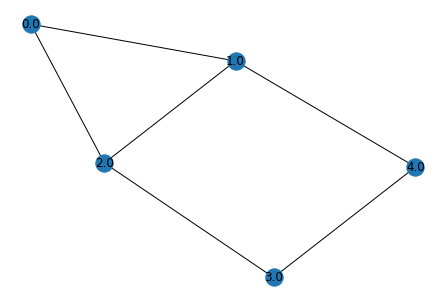

In [93]:
G = nx.Graph()
G.add_nodes_from(np.arange(0, nodes, 1))
G.add_weighted_edges_from(edges)
nx.draw(G, with_labels=True)

In [106]:
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

"""declarative approach
algorithm_cfg = {
    'name': 'VQE'
}

optimizer_cfg = {
    'name': 'SPSA',
    'max_trials': 300
}

var_form_cfg = {
    'name': 'RY',
    'depth': 5,
    'entanglement': 'linear'
}

params = {
    'problem': {'name': 'ising', 'random_seed': seed},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'backend': {provider': 'qiskit.BasicAer', 'name': 'statevector_simulator'}
}

result = run_algorithm(params, algo_input)
"""

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(4)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

energy: -7.99649120881894
time: 17.216977834701538
max-cut objective: -3.9964912088189397
solution: [0. 1. 1. 1.]
solution objective: 4.0


NameError: name 'pos' is not defined